In [ ]:
import networkx as nx
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
from scipy.stats import poisson

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
brain = nx.read_edgelist("/content/bn-mouse-kasthuri_graph_v4.edges")

## Numero di nodi e archi




In [ ]:
len(brain.nodes)

1029

In [ ]:
len(brain.edges)

1559

## Density

In [ ]:
density = nx.density(brain)
density

0.0029475937123042656

Non è sparsa quanto un social network ma è molto sparsa.

# Degree Distribution

Vediamo media, mediana, deviazione standard, range interquartile, minimo e massimo

Recuperiamo i gradi

In [ ]:
degrees = list(dict(brain.degree()).values())

In [ ]:
print('Mean degree: \t​​​​'+ str(np.mean(degrees)))
print('Standard deviation: ​​​​' + str(np.std(degrees)))
print('Median: ' + str(np.median(degrees)))
print('iqr: ' + str(np.quantile(degrees, 0.75) - np.quantile(degrees, 0.25)))
print('Min: ​​​​' + str(np.min(degrees)))
print('Max: ​​​​' + str(np.max(degrees)))


Mean degree: 	​​​​3.0301263362487854
Standard deviation: ​​​​6.286646968804228
Median: 2.0
iqr: 2.0
Min: ​​​​1
Max: ​​​​123


Nelle reti scale free la media è molto più alta della mediana (influencers) invece  qua sono vicine ma non coincidono quindi già abbiamo un dubbio che sia broad scale

Cosa stampiamo? Normalmente la fuzione di massa probabilità ma attenti agli influencer. Se ci sono non riesce a catturare l'intero range dei valori. Allora sicuro usiamo le scale logaritmica. MA se stampiamo l'ecdf complementare. se la curva è ripida la distribuzione è poisson, se alla fine Pareto se in mezzo broad scale. Stampiamo entrambe.

Facciamo i random graph equivalente del cervello di sto topo che avrà distribuzione dei single scale (grafo di Herdos-Reini)




In [ ]:
random_graph_herdos = nx.fast_gnp_random_graph(len(brain.nodes), nx.density(brain))
len(random_graph_herdos.nodes), len(random_graph_herdos.edges)

(1029, 1566)

Si avvicina molto, un po' meno di archi. Plottiamo ste cazzo di distrubizioni pdio ma prima il deegree....

In [ ]:
random_degrees = list(dict(random_graph_herdos.degree()).values())

Text(0, 0.5, 'ECCDF')

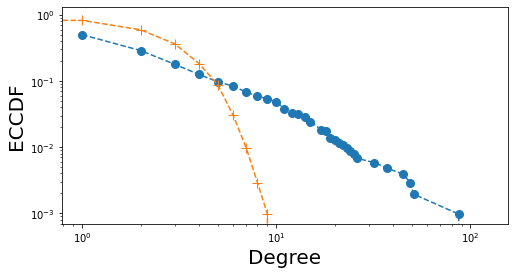

In [ ]:
cdf = ECDF(degrees)
x = np.unique(degrees)
y = cdf(x)

cdf_random = ECDF(random_degrees)
x_random = np.unique(random_degrees)
y_random = cdf_random(x_random)
 
fig_cdf_fb = plt.figure(figsize=(8,4))
axes = fig_cdf_fb.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.loglog(x_random,1-y_random,marker='+',ms=10, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size = 20)

Quello random è arancione. Il cervello del topo quello blu. Quello arancione segue la distribuzione di poisson e non riesce a catturare i piccoli influencer che ci sono nel grafo, mentre l'altra scende meno velocemente e evidenzia la presenza di piccoli influencer di grado 100 (forse solo 1)

Ma pare pareto? Non mi pare. Tò, mon sembra che siamo negli ordini della grandezza della scale free. Quindi una broad scale

Per i bro fan di san tommaso, plottiamo l'ecdf una Poissoniana di parametro media della random e l'ecdf della random.

Text(0, 0.5, 'CDF')

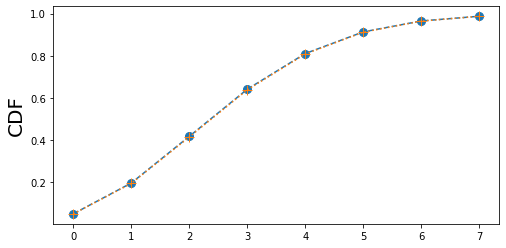

In [24]:
mu = np.mean(degrees)
x = np.arange(poisson.ppf(0.01, mu),poisson.ppf(0.99, mu))
prob = poisson.cdf(x, mu) 

mu_random = np.mean(random_degrees)
x_random = np.arange(poisson.ppf(0.01, mu_random),poisson.ppf(0.99, mu_random))
prob_random = poisson.cdf(x_random, mu_random) 
 
#plt.plot((x),(prob), drawstyle =  "steps", color='r', linewidth = 5)

fig_cdf_fb = plt.figure(figsize=(8,4))
axes = fig_cdf_fb.gca()
#axes.set_xscale('log')
#axes.set_yscale('log')
axes.plot(x,prob,marker='o',ms=8, linestyle='--')
axes.plot(x_random,prob_random,marker='+',ms=10, linestyle='dotted')
#axes.set_xlabel('',size=20)
axes.set_ylabel('CDF', size = 20)

Sono esattamente stessa cosa, sono sovrapposte

# Connectivity

E' un grafo connesso?

In [ ]:
nx.is_connected(brain)

False

C'è una giant component?

In [ ]:
components =  nx.connected_components(brain)
component_list = list(components)
component_list

[{'0',
  '1',
  '10',
  '100',
  '1000',
  '1001',
  '1002',
  '1003',
  '1004',
  '1005',
  '1006',
  '1007',
  '1008',
  '1009',
  '101',
  '1010',
  '1011',
  '1012',
  '1013',
  '1015',
  '1016',
  '1017',
  '1018',
  '1019',
  '102',
  '1020',
  '1021',
  '1022',
  '1023',
  '1024',
  '1025',
  '1026',
  '1027',
  '1028',
  '103',
  '104',
  '105',
  '106',
  '107',
  '108',
  '109',
  '11',
  '110',
  '111',
  '112',
  '113',
  '114',
  '115',
  '116',
  '117',
  '118',
  '119',
  '12',
  '120',
  '121',
  '122',
  '123',
  '124',
  '125',
  '126',
  '127',
  '128',
  '129',
  '13',
  '130',
  '131',
  '132',
  '133',
  '134',
  '135',
  '136',
  '137',
  '138',
  '139',
  '14',
  '140',
  '141',
  '142',
  '143',
  '144',
  '145',
  '146',
  '147',
  '148',
  '149',
  '15',
  '150',
  '151',
  '152',
  '153',
  '154',
  '155',
  '156',
  '157',
  '158',
  '159',
  '16',
  '160',
  '161',
  '162',
  '163',
  '164',
  '165',
  '166',
  '167',
  '168',
  '169',
  '17',
  '170',
  '

Numero delle componenti connesse:

In [ ]:
len(component_list)

20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


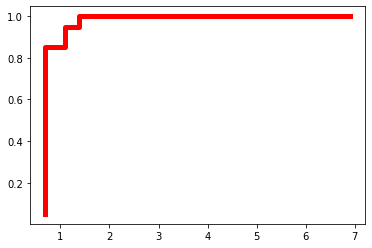

In [ ]:
sorted_components = sorted(component_list, key = lambda x : len(x), reverse=True)
len_of_components = list ( map ( lambda x :  len(x) ,sorted_components ))
ecdf = ECDF(len_of_components)
plt.step(np.log(ecdf.x),ecdf.y, color = 'r', linewidth = 5)


C'è la giant component! Più dell'80%!

# Small World

Non c'è tanto da fare dobbiamo solo calcolare il diametro. c'è il metodo yasss

In [ ]:
giant_component=brain.subgraph(sorted_components[0])
nx.diameter(giant_component)

12

Ci conferma che non è proprio small world (ma è un topo!). E il cervello umano?....